# Imbalanced data sets

One way bias may get introduced into your model is if your data is imbalanced. Let's use the [adult income dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv) (pre-download in the files-folder).

We'll be using [this](https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/) example.


https://github.com/Trusted-AI/AIF360



## Import data
First, import the data. We use read_csv from pandas to create a dataframe, drop the rows containing NA and visualize the imbalance in the dataset.

In [1]:
# load and summarize the dataset
from pandas import read_csv
from collections import Counter
# define the dataset location
filename = 'files/adult-all.csv'
# load the csv file as a data frame
df = read_csv(filename, header=None, na_values='?')
# drop rows with missing
df = df.dropna()
# summarize the shape of the dataset
print(df.shape)
# summarize the class distribution
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
 per = v / len(target) * 100
 print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

(45222, 15)
Class=<=50K, Count=34014, Percentage=75.216%
Class=>50K, Count=11208, Percentage=24.784%


Next up, let's take all the numerical fields and graph them in boxplots. Some are distributed in a normal fashion, others more randomly.

You should notice however the enormous difference in scale: Variable 2 is always below 1.5, variable 10 goes up to 100.000. This we can solve using scaling.

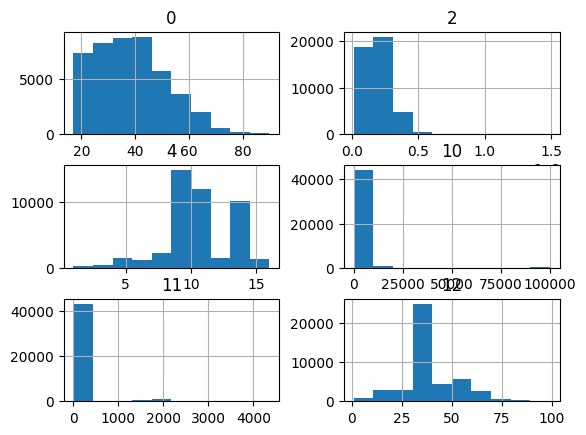

In [2]:
from matplotlib import pyplot

# select columns with numerical data types
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
# select a subset of the dataframe with the chosen columns
subset = df[num_ix]
# create a histogram plot of each numeric variable
subset.hist()
pyplot.show()

## Model Test and Baseline Result

As the code online states:
We will evaluate candidate models using repeated stratified k-fold cross-validation.

The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, at least compared to a single train-test split. We will use k=10, meaning each fold will contain about 45,222/10, or about 4,522 examples.

Stratified means that each fold will contain the same mixture of examples by class, that is about 75 percent to 25 percent for the majority and minority classes respectively. Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. We will use three repeats.

This means a single model will be fit and evaluated 10 * 3 or 30 times and the mean and standard deviation of these runs will be reported.

This can be achieved using the RepeatedStratifiedKFold scikit-learn class.

We will predict a class label for each example and measure model performance using classification accuracy.

The evaluate_model() function below will take the loaded dataset and a defined model and will evaluate it using repeated stratified k-fold cross-validation, then return a list of accuracy scores that can later be summarized.

Which comes down to:

In [3]:
# test harness and baseline model evaluation for the adult dataset
from collections import Counter
from numpy import mean
from numpy import std
from numpy import hstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
 
# load the dataset
def load_dataset(full_path):
 # load the dataset as a numpy array
 dataframe = read_csv(full_path, header=None, na_values='?')
 # drop rows with missing
 dataframe = dataframe.dropna()
 # split into inputs and outputs
 last_ix = len(dataframe.columns) - 1
 X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
 # select categorical and numerical features
 cat_ix = X.select_dtypes(include=['object', 'bool']).columns
 num_ix = X.select_dtypes(include=['int64', 'float64']).columns
 # label encode the target variable to have the classes 0 and 1
 y = LabelEncoder().fit_transform(y)
 return X.values, y, cat_ix, num_ix
 
# evaluate a model
def evaluate_model(X, y, model):
 # define evaluation procedure
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 # evaluate model
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
 return scores
 
# define the location of the dataset
full_path = 'files/adult-all.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='most_frequent')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

(45222, 14) (45222,) Counter({np.int64(0): 34014, np.int64(1): 11208})
Mean Accuracy: 0.752 (0.000)


## Evaluate models

Finally, the codes applies a number of different models to the dataset and compares the result.

Warning: the next code block will take a long time to run.

In [ ]:
# spot check machine learning algorithms on the adult imbalanced dataset
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

 
# define models to test
def get_models():
 models, names = list(), list()
 # CART
 models.append(DecisionTreeClassifier())
 names.append('CART')
 # SVM
 models.append(SVC(gamma='scale'))
 names.append('SVM')
 # Bagging
 models.append(BaggingClassifier(n_estimators=100))
 names.append('BAG')
 # RF
 models.append(RandomForestClassifier(n_estimators=100))
 names.append('RF')
 # GBM
 models.append(GradientBoostingClassifier(n_estimators=100))
 names.append('GBM')
 return models, names
 
# define the location of the dataset
full_path = 'files/adult-all.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
 # define steps
 steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
 # one hot encode categorical, normalize numerical
 ct = ColumnTransformer(steps)
 # wrap the model i a pipeline
 pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
 # evaluate the model and store results
 scores = evaluate_model(X, y, pipeline)
 results.append(scores)
 # summarize performance
 print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>CART 0.811 (0.007)


This exercises did not contain any actual exercises. The code was too heavy to reasonably expect you to write it yourself now. Make sure you understand it though, as it does contain a number of interesting points.